In [1]:
from tempo_detector import TempoDetector
import io_utils
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
TEST_BUCKETS = [(1.0/64,), (1.0/32,), (1.0/32, 'd'), (1.0/32, 't'), (1.0/16, 'd'), (1.0/16, 't'), (1.0/16,),
                (1.0/8, 'd'), (1.0/8, 't'), (1.0/8,),
                (1.0/4, 'd'), (1.0/4, 't'), (1.0/4,),
                (1.0/2, 'd'), (1.0/2,),
                (1.0,), (2.0,), (3.0,), (4.0,), (5.0,)]

# SIMPLE_BUCKETS = TEST_BUCKETS
SIMPLE_BUCKETS = [(1.0/32,),  (1.0/16, 't'), (1.0/16, 'd'), (1.0/16,),
                (1.0/8, 'd'), (1.0/8, 't'), (1.0/8,),
                (1.0/4, 'd'), (1.0/4, 't'), (1.0/4,),
                (1.0/2, 'd'), (1.0/2,),
                (1.0,)]

In [3]:
DIRS = ['debussy', 'mozart', 'beeth', 'chopin', 'bach']
# DIRS = ['mozart']
OUTPUT_DIR = 'predicted_tempos'
START_TEMPOS = range(40, 200, 10)

In [4]:
def predictTempos(E_time_mat, detector):
    predicted_tempos = []
    for i in range(len(E_time_mat)):
        if i % 5 == 0:
            print i, '/', len(E_time_mat)
        detector.setBuckets(TEST_BUCKETS)
        candidates_with_losses = [detector.predict(E_time_mat[i], t, detector.linearDistanceFunction, \
                            detector.linearDistanceFunctionGradient, lambda x: 1) for t in START_TEMPOS]
        candidates_with_losses = list(set(candidates_with_losses))
        print candidates_with_losses
        candidates = [c for c, l in candidates_with_losses]
        E_pred_mat, sigs = io_utils.generatePredictedTempoMatrix(filenames[i], TEST_BUCKETS, candidates)
        detector.setBuckets(SIMPLE_BUCKETS)
        candidates_bucketed_loss = [(c, detector.computeLoss(c, E_time_mat[i], detector.logDistanceFunction)) \
                                       for c in candidates]
        tempo_options = sorted(candidates_bucketed_loss, key=lambda x: x[1])
        predicted_tempos.append([tempo_options[i][0] for i in range(len(tempo_options))])
    return predicted_tempos

In [28]:
def compareTempos(predicted_tempos, actual_tempos):
    comparison = []
    predicted_tempos = [int(t) for t in predicted_tempos]
    actual_tempos = [int(t) for t in actual_tempos]
    for i in range(len(predicted_tempos)):
        absolute_diff = abs(predicted_tempos[i] - actual_tempos[i])
        pred_over_actual = predicted_tempos[i] / actual_tempos[i]
        if pred_over_actual > 0:
            scale = pred_over_actual
            scaled_diff = min(abs(predicted_tempos[i] - actual_tempos[i] * scale), \
                              abs(predicted_tempos[i] - actual_tempos[i] * (scale+1)))
        else:
            scale = actual_tempos[i] / predicted_tempos[i]
            scaled_diff = min(abs(actual_tempos[i] - scale * predicted_tempos[i]), \
                              abs(actual_tempos[i] - (scale+1) * predicted_tempos[i]))
        comparison.append((absolute_diff, scale, scaled_diff, predicted_tempos[i], actual_tempos[i]))
    return comparison

def compareTempoCandidates(predicted_candidates, actual_tempos, n, max_percent_diff):
    n_in_max_diff = 0
    for i in range(len(predicted_candidates)):
        min_diff = min(abs(float(t) / actual_tempos[i] - 1) for t in predicted_candidates[i][:n])
        print actual_tempos[i]
        print min_diff
        if min_diff < max_percent_diff:
            n_in_max_diff += 1
    return float(n_in_max_diff) / len(predicted_candidates)

def compareTempoCandidatesFlexible(predicted_candidates, actual_tempos, n, error_percent_range, tempo_infos, tempo_quartile_percent):
    def flexibleCompare(y_hat, y):
        accepted = [.25, .5, 1., 2., 4.]
        diffs = [float(y_hat) / (actual_tempos[i] * a) - 1 for a in accepted]
        print diffs
        t = min((t for t in diffs), key=lambda x: abs(x))
        print t
        return t
#         return min(abs(float(y_hat) / (actual_tempos[i] * a) - 1) for a in accepted)
#         mult = math.floor(y_hat / y)
#         print 'tempos', y_hat, y
#         print mult
#         c1 = abs(float(y_hat) * mult / y - 1)
#         c2 = abs(float(y_hat) * (mult - 1) / y - 1)
#         print c1, c2
#         return min(c1, c2)

    def acceptableTempos(info, limit_percent):
        diff = info[3] - info[1]
        print info
        percent_diff = float(diff) / info[2]
        return percent_diff < limit_percent
    
    n_in_max_diff = 0
    total = 0
    skipped = 0
    for i in range(len(predicted_tempos)):
        info = tempo_infos[i]
        if not acceptableTempos(info, tempo_quartile_percent): 
            skipped += 1
            continue
        else:
            total += 1
        print total
        min_diff = min( ((flexibleCompare(t, actual_tempos[i]), t) for t in predicted_candidates[i][:n]), key=lambda x:abs(x[0]))
        if min_diff[0] >= error_percent_range[0] and min_diff[0] <= error_percent_range[1]:
            n_in_max_diff += 1
#         else:
#             print 'YOU SUCK'
#             print actual_tempos[i]
#             print min_diff
    print 'Total', total
    print 'Skipped', skipped
    print 'Good', n_in_max_diff
    return float(n_in_max_diff) / total


def generateRankedByLog(candidate_tempos, E_time_mat, detector):
    tempos = []
    for i in range(len(candidate_tempos)):
        ranked_by_log = [(t, detector.computeLoss(t, E_time_mat[i], detector.logDistanceFunction)) for t in candidate_tempos[i]]
        ranked_by_log = sorted(ranked_by_log, key=lambda x: x[1])
        ranked_by_log = [t for t, l in ranked_by_log]
        tempos.append(ranked_by_log)
    return tempos

In [6]:
E_time_mat, tempos, filenames, tempo_infos = io_utils.generateTempoPredictionDataLimited(DIRS)

In [7]:
len(filenames)

110

In [8]:
detector = TempoDetector(TEST_BUCKETS)

[25.0, 50.0, 75.0, 33.33333333333333, 150.0, 66.66666666666666, 100.0, 300.0, 133.33333333333331, 200.0, 600.0, 266.66666666666663, 400.0, 1200.0, 800.0, 1600.0, 3200.0, 4800.0, 6400.0, 8000.0]


In [10]:
predicted_tempos = predictTempos(E_time_mat, detector)


0 / 110
[(130, 3293735), (62, 737365), (47, 175558), (94, 653566), (141, 4000254), (68, 834210), (34, 65477)]
[(135, 636718), (155, 1203099), (134, 625547), (70, 216124), (81, 375775), (150, 1078539), (113, 620644)]
[(60, 68715), (169, 2789108), (63, 84115), (44, 47180), (119, 264802), (86, 152708)]
[(77, 125176), (111, 371778), (150, 1757979), (82, 121265), (153, 1679232), (41, 44708), (55, 93049)]
[(91, 96407), (160, 688808), (44, 42254), (44, 42235), (81, 59740), (181, 912487), (124, 93089), (62, 36306), (182, 914901)]
5 / 110
[(108, 263311), (59, 119855), (76, 215731), (151, 1285876), (215, 1438586), (57, 112694)]
[(64, 395129), (131, 791105), (47, 1012842), (41, 704349), (94, 94026), (172, 3115102)]
[(47, 257556), (93, 1130286), (136, 3244847), (95, 1018887), (62, 981853)]
[(71, 362020), (91, 251080), (48, 127019), (136, 543325), (177, 1886757)]
[(163, 1254240), (85, 795932), (129, 3497337)]
10 / 110
[(92, 506809), (182, 1863736), (47, 214416), (135, 909056), (68, 261512)]
[(110, 

[(81, 243122), (160, 1157475), (116, 3361865), (55, 416378), (41, 52615)]
[(153, 613867), (57, 13777), (113, 48075), (98, 58699), (79, 11999), (118, 70279), (56, 11991), (169, 450962), (79, 12307)]
[(486, 1539812)]
90 / 110
[(101, 73361), (76, 37007), (51, 16455), (201, 293987), (69, 24301), (153, 148421), (38, 9295)]
[(176, 746448), (160, 661871), (62, 20642), (86, 46469), (126, 114283), (86, 48039), (167, 743978), (45, 23859), (127, 122932), (51, 59338)]
[(53, 12974), (72, 9897), (130, 67262), (103, 31457), (133, 48806), (103, 31969), (150, 37568), (67, 13864), (175, 155492), (76, 14431), (127, 76180), (89, 43645), (177, 161807)]
[(65, 604277), (106, 1579629), (53, 221310), (131, 1138382), (106, 1576545), (66, 638949), (72, 868485), (38, 214885)]
[(422, 9060736)]
95 / 110
[(159, 13971), (42, 9117), (116, 16705), (59, 5075), (79, 4951)]
[(44, 61581), (61, 408321), (182, 2503946), (44, 62724), (86, 440055)]
[(170, 645854), (196, 284593), (180, 551335), (64, 22462), (86, 13557), (127, 8

In [50]:
compareTempoCandidatesFlexible(predicted_tempos, tempos, 3, (-.08, .10), tempo_infos, .2)

[8.0, 71.49998629583595, 76.99997818333952, 90.5000580708706, 132.50005520835634]
[53.000022083342536, 80.49995840835483, 93.50003350417867, 102.0000510000255, 130.00013000013]
[135.000135000135, 168.16991888604247, 173.8097652119755, 177.1599488598281, 185.50007729169886]
1
[2.8893096666666667, 0.9446548333333333, -0.027672583333333334, -0.5138362916666667, -0.7569181458333334]
-0.0276725833333
[1.7386263333333334, 0.3693131666666667, -0.31534341666666665, -0.6576717083333333, -0.8288358541666667]
-0.315343416667
[0.9791753333333333, -0.010412333333333357, -0.5052061666666667, -0.7526030833333334, -0.8763015416666666]
-0.0104123333333
[58.40001479467041, 105.50007033338022, 110.9999056500802, 113.78009720612971, 130.18996886289912]
2
[4.5135182, 1.7567591, 0.37837955, -0.310810225, -0.6554051125]
-0.310810225
[4.40541, 1.702705, 0.35135249999999996, -0.32432375, -0.662161875]
-0.32432375
[3.0000033999999998, 1.0000016999999999, 8.499999999411756e-07, -0.49999957500000003, -0.749999787

0.8163265306122449

In [11]:
print len(predicted_tempos)
print len(tempos)

103
103


In [51]:
tempo_success = [compareTempoCandidatesFlexible(predicted_tempos, tempos, i, (-.08, .10), tempo_infos, .2) for i in range(1, 6)]

[8.0, 71.49998629583595, 76.99997818333952, 90.5000580708706, 132.50005520835634]
[53.000022083342536, 80.49995840835483, 93.50003350417867, 102.0000510000255, 130.00013000013]
[135.000135000135, 168.16991888604247, 173.8097652119755, 177.1599488598281, 185.50007729169886]
1
[2.8893096666666667, 0.9446548333333333, -0.027672583333333334, -0.5138362916666667, -0.7569181458333334]
-0.0276725833333
[58.40001479467041, 105.50007033338022, 110.9999056500802, 113.78009720612971, 130.18996886289912]
2
[4.5135182, 1.7567591, 0.37837955, -0.310810225, -0.6554051125]
-0.310810225
[85.12002633046149, 120.80990963418759, 123.52007510020566, 124.88006310605856, 130.92004058521258]
3
[4.8937788, 1.9468893999999999, 0.47344469999999994, -0.26327765000000003, -0.631638825]
-0.26327765
[21.009999709361672, 72.09995938368955, 74.4900226822119, 77.359962351485, 92.15995281410416]
4
[10.545170333333335, 4.772585166666667, 1.8862925833333337, 0.44314629166666686, -0.27842685416666657]
-0.278426854167
[57.8

[32.410008210535416, 65.40999530138201, 67.09998344867076, 69.27998466603006, 75.72000257448009]
12
[9.909093599999999, 4.454546799999999, 1.7272733999999996, 0.3636366999999998, -0.3181816500000001]
-0.31818165
[6.988079466666666, 2.994039733333333, 0.9970198666666665, -0.001490066666666734, -0.5007450333333334]
-0.00149006666667
[5.020865866666666, 2.010432933333333, 0.5052164666666665, -0.24739176666666673, -0.6236958833333334]
-0.247391766667
[32.57999338626134, 70.65997595205485, 73.66003194390052, 74.73003773866905, 88.00002346667293]
13
[10.5666526, 4.7833263, 1.8916631499999998, 0.4458315749999999, -0.27708421250000004]
-0.2770842125
[6.874012333333333, 2.9370061666666665, 0.9685030833333332, -0.01574845833333338, -0.5078742291666667]
-0.0157484583333
[4.8647816, 1.9323907999999999, 0.4661953999999999, -0.26690230000000004, -0.63345115]
-0.2669023
[43.930007782933046, 54.93001458391887, 55.929975670460585, 56.929993187377484, 58.93000784751271]
14
[11.086542, 5.043271, 2.021635

-0.261520266667
[3.0900415999999993, 1.0450207999999996, 0.02251039999999982, -0.4887448000000001, -0.7443724]
0.0225104
[2.0959342666666663, 0.5479671333333331, -0.22601643333333343, -0.6130082166666667, -0.8065041083333333]
-0.226016433333
[1.1302299999999996, 0.06511499999999981, -0.4674425000000001, -0.7337212500000001, -0.866860625]
0.065115
[30.389994803310888, 43.990011334759586, 45.19001270592524, 45.99001556762027, 123.30000123300002]
25
[14.844208866666666, 6.922104433333333, 2.9610522166666664, 0.9805261083333332, -0.0097369458333334]
-0.00973694583333
[10.772512733333333, 4.886256366666666, 1.9431281833333331, 0.4715640916666666, -0.2642179541666667]
-0.264217954167
[6.966361999999999, 2.9831809999999996, 0.9915904999999998, -0.00420475000000009, -0.502102375]
-0.00420475
[4.8419988, 1.9209994, 0.46049969999999996, -0.26975015, -0.6348750750000001]
-0.26975015
[4.487938266666666, 1.7439691333333331, 0.37198456666666657, -0.3140077166666667, -0.6570038583333333]
-0.314007716

[1 2 3 4 5]
[ 41.83673469  73.46938776  81.63265306  90.81632653  90.81632653]


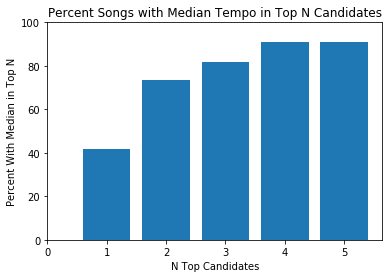

In [52]:
success_y = np.array(tempo_success)
x = np.arange(1,6)
success_y *= 100
print x
print success_y
plt.bar(x, success_y)
plt.title('Percent Songs with Median Tempo in Top N Candidates')
plt.xlabel('N Top Candidates')
plt.ylabel('Percent With Median in Top N')
axes = plt.gca()
axes.set_ylim([0, 100])
plt.xticks(np.arange(6))
plt.show()